In [10]:
import numpy as np
import pandas as pd

df = pd.read_csv("dermatology.csv", sep='\t', encoding="utf-8-sig", na_values="?")

df.columns = df.columns.str.strip()

#only establishing variables
Xfull = df.iloc[:,:-1].to_numpy()
yDisease = df.iloc[:,-1].to_numpy()

mean_value = np.nanmean(Xfull)

# Replace NaNs with the mean
Xfull[np.isnan(Xfull)] = mean_value

print("Total NaNs in X_train:", np.isnan(Xfull).sum())

X_age = df["Age"].to_numpy().copy()
mean_value = np.nanmean(X_age)

X_age[np.isnan(X_age)] = mean_value

print(X_age)
print(yDisease)

def add_bias(X):
    """
    Add a column of ones so the model can learn an intercept term.
    If X is (n, d), output is (n, d+1).
    """
    return np.c_[np.ones((X.shape[0], 1)), X]

def one_hot(y, K):
    """
    Convert integer labels into one-hot rows.

    TODO (completed):
    1) Create a zeros matrix (n, K)
    2) Set the correct class index to 1 for each row
    """
    y = np.asarray(y).astype(int)
    n = y.shape[0]
    Y = np.zeros((n, K))
    Y[np.arange(n), y] = 1.0
    return Y

def softmax(Z):
    """
    Stable softmax for (n, K) scores.

    TODO (completed):
    1) Subtract max per row for numerical stability
    2) Exponentiate and normalize so each row sums to 1
    """
    Z = np.asarray(Z)
    Z_shift = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z_shift)
    return expZ / np.sum(expZ, axis=1, keepdims=True)

def softmax_loss_and_grad(Xb, y_int, W, l2=0.0):
    """
    Softmax regression: average cross-entropy loss and gradient.

    TODO (completed):
    1) Compute scores and softmax probabilities
    2) Compute average cross-entropy loss
    3) Compute gradient dW
    4) Add L2 penalty and gradient on W[1:,:] only
    """
    n = Xb.shape[0]
    K = W.shape[1]

    scores = Xb @ W
    probs = softmax(scores)
    Y = one_hot(y_int, K)

    eps = 1e-12
    p_true = np.sum(probs * Y, axis=1)
    loss = np.mean(-np.log(p_true + eps))

    dScores = (probs - Y) / n
    dW = Xb.T @ dScores

    if l2 > 0.0:
        loss += (l2 / 2.0) * np.sum(W[1:, :] ** 2)
        reg_grad = np.zeros_like(W)
        reg_grad[1:, :] = l2 * W[1:, :]
        dW += reg_grad

    return loss, dW

def train_softmax_gd(Xb_train, y_train, Xb_val, y_val, K,
                     lr=0.1, steps=3000, l2=0.0, verbose_every=300):
    """
    Train softmax regression with gradient descent.

    TODO (completed):
    1) Initialize W zeros with shape (d+1, K)
    2) Run gradient descent using softmax_loss_and_grad
    3) Track train and val loss
    4) Return W and history
    """
    d = Xb_train.shape[1]
    W = np.zeros((d, K))

    train_loss_hist = []
    val_loss_hist = []

    for t in range(steps):
        tr_loss, gradW = softmax_loss_and_grad(Xb_train, y_train, W, l2=l2)
        W = W - lr * gradW

        va_loss, _ = softmax_loss_and_grad(Xb_val, y_val, W, l2=l2)
        train_loss_hist.append(tr_loss)
        val_loss_hist.append(va_loss)

        if verbose_every is not None and (t % verbose_every == 0 or t == steps - 1):
            pass

    history = {"train_loss": train_loss_hist, "val_loss": val_loss_hist}
    return W, history

def split_train_val_test(X, y, train_size=0.6, val_size=0.2, test_size=0.2, seed=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-9
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    n_train = int(train_size * n)
    n_val = int(val_size * n)
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train+n_val]
    test_idx = idx[n_train+n_val:]
    return X[train_idx], y[train_idx], X[val_idx], y[val_idx], X[test_idx], y[test_idx]

def predict_softmax(Xb, W):
    probs = softmax(Xb @ W)
    return np.argmax(probs, axis=1)

avg_acc = 0
seed_min = 0
seed_max = 100

K=7

for i in range(seed_min, seed_max + 1):
    #X_train, y_train, X_test, y_test = split_train_val_test(X_age, yDisease, seed=i)
    Xtr, ytr, Xva, yva, Xte, yte = split_train_val_test(X_age, yDisease, seed=i)
    Xbtr = add_bias(Xtr)
    Xbva = add_bias(Xva)
    Xbte = add_bias(Xte)

    w_hat,cost_hist = train_softmax_gd(Xbtr, ytr, Xbva, yva, K=K, lr=0.001, steps=1000, l2=1e-3)

    yhat = predict_softmax(Xbte, w_hat)
    test_acc = np.mean(yhat == yte)
    print("Test accuracy (softmax from scratch):", test_acc)

    avg_acc += test_acc

avg_acc /= (seed_max - seed_min + 1)

print(f'Test Average Accuracy: %{avg_acc * 100:.2f}')


df = pd.read_csv("dermatology.csv", sep="\t", na_values="?", encoding="utf-8-sig")

df.columns = df.columns.str.strip()

y_val = df.iloc[:, -1]
X_val_all = df.iloc[:, :33]
X_val_clinc = df.iloc[:, :11]
X_val_histo = df.iloc[:, 11:33]

Total NaNs in X_train: 0
[55.          8.         26.         40.         45.         41.
 18.         57.         22.         30.         20.         21.
 22.         10.         65.         40.         30.         38.
 23.         17.          8.         51.         42.         44.
 22.         33.         10.         17.         43.         50.
 50.         10.         34.         36.29608939 36.29608939 36.29608939
 36.29608939 15.         26.         46.         51.         62.
 15.         35.         30.         48.         46.         12.
 52.         60.         32.         35.         41.         48.
 51.         19.         22.         29.         25.         33.
  8.         40.         33.         42.         36.         60.
 36.         21.         40.         21.         34.         13.
 52.         48.         17.         25.         33.         62.
 52.         27.         40.         31.         27.         10.
 55.         30.         42.         48.         22.     

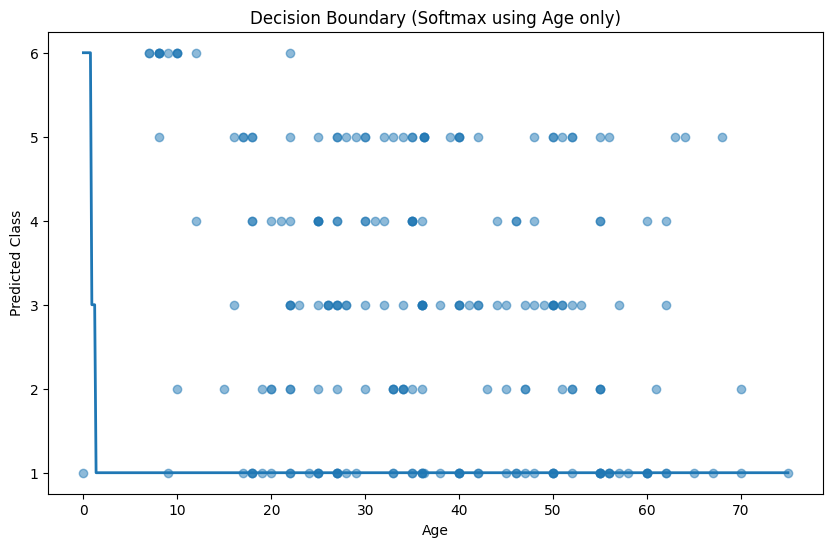

In [11]:
import matplotlib.pyplot as plt

# following graphs were made by chatgpt

# Use one split
Xtr, ytr, Xva, yva, Xte, yte = split_train_val_test(X_age, yDisease, seed=42)

Xbtr = add_bias(Xtr)
Xbva = add_bias(Xva)

K = 7
W, history = train_softmax_gd(Xbtr, ytr, Xbva, yva,
                              K=K, lr=0.001,
                              steps=2000, l2=1e-3)

age_min, age_max = X_age.min(), X_age.max()
age_grid = np.linspace(age_min, age_max, 500).reshape(-1,1)

Xb_grid = add_bias(age_grid)
probs = softmax(Xb_grid @ W)
pred_classes = np.argmax(probs, axis=1)

plt.figure(figsize=(10,6))

# Plot decision regions
plt.plot(age_grid, pred_classes, linewidth=2)

# Scatter actual training data
plt.scatter(Xtr, ytr, alpha=0.5)

plt.xlabel("Age")
plt.ylabel("Predicted Class")
plt.title("Decision Boundary (Softmax using Age only)")
plt.show()

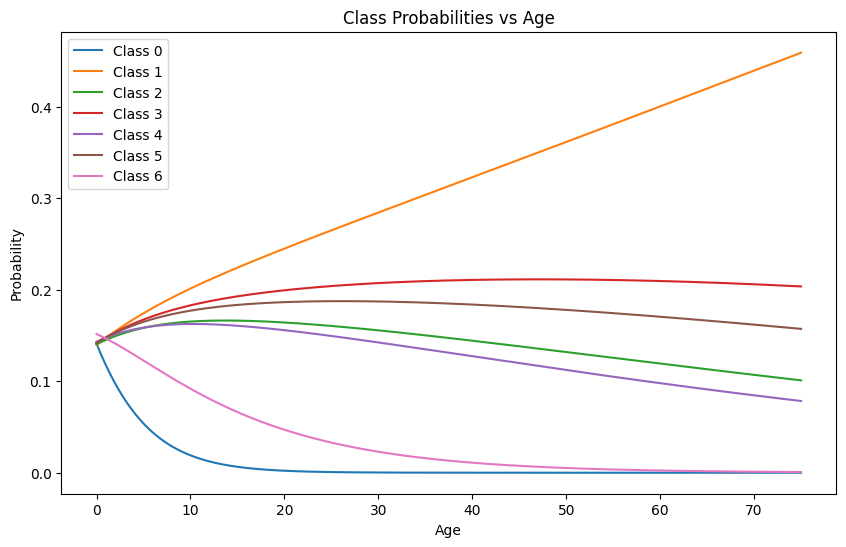

In [12]:
plt.figure(figsize=(10,6))

for k in range(K):
    plt.plot(age_grid, probs[:,k], label=f"Class {k}")

plt.xlabel("Age")
plt.ylabel("Probability")
plt.title("Class Probabilities vs Age")
plt.legend()
plt.show()